In [133]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import keras.layers as tfl
import tensorflow as tf
from keras.utils import image_dataset_from_directory


# Visualisation des données


In [134]:

BATCH_SIZE = 32
IMG_SIZE = (320, 320)
directory = "dataset/"

train_dataset : tf.data.Dataset = image_dataset_from_directory(directory,
                                       shuffle=True,
                                       batch_size=BATCH_SIZE,
                                       image_size=IMG_SIZE,
                                       validation_split=0.2,
                                       subset='training',
                                       seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                       shuffle=True,
                                       batch_size=BATCH_SIZE,
                                       image_size=IMG_SIZE,
                                       validation_split=0.2,
                                       subset='validation',
                                       seed=42)




Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


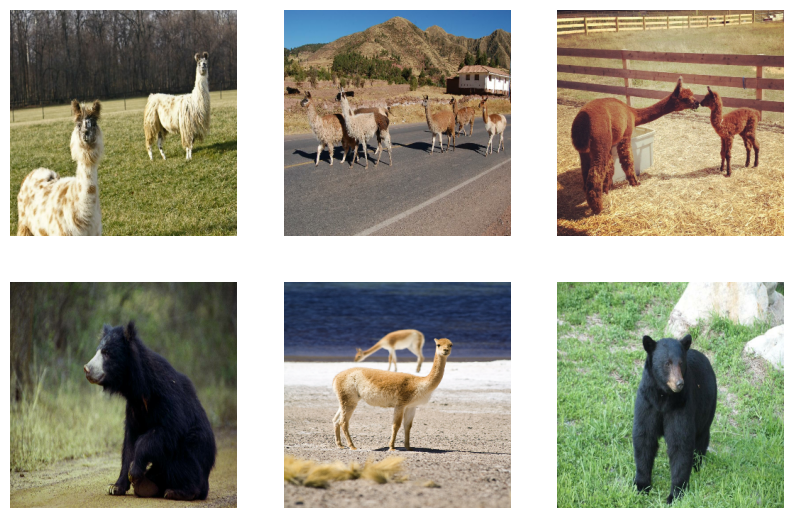

In [135]:
plt.figure(figsize=(10, 10))
for images,labels in train_dataset.take(1):
    
    for i in range(6):
        image = images[i].numpy()
        ax = plt.subplot(3,3,i+1)
        plt.imshow(image.astype('uint8'))
        plt.axis('off')

# Data Augmentation

In [136]:
def data_augmenter():
    '''
    Crée un modèle sequentiel composé de 2 couches
    Retourne: 
        tf.keras.Sequential
    '''
    data_augmentation = keras.Sequential()
    data_augmentation.add(tfl.RandomFlip(mode='horizontal'))
    data_augmentation.add(tfl.RandomRotation(0.2))
    data_augmentation.add(tfl.RandomFlip(mode='horizontal'))
    data_augmentation.add(tfl.RandomRotation(0.4))

    return data_augmentation

Visualisation de la data augmentée



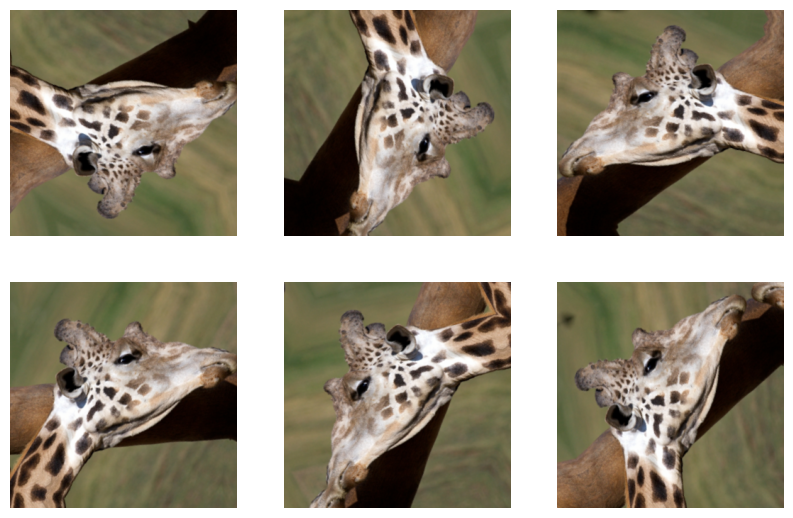

In [137]:

augmenter = data_augmenter()
plt.figure(figsize=(10, 10))
for images,labels in train_dataset.take(1):
    image1 = images[0]
    for i in range(6):
        image = augmenter(image1)
        ax = plt.subplot(3,3,i+1)
        plt.imshow(image/255)
        plt.axis('off')

prefetch de la data de manière oprimisée

In [138]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

# Utilisation du modèle MobileNetV2 pour faire du transfer learning

In [139]:
def model_perso(image_shape = IMG_SIZE, data_augmenter = data_augmenter()):

    '''
    Crée un model sur la base du modele MobileNetV2.
    Modification de la dernière couche pour avoir 2 logit plutot que 1000 de base
    Arguments:
        image_shape -- taille de l'image (tuple)
        data_augmenter -- la foonction qui crée un keras.Sequential pour l'augmentation de données
    Retourne:
        keras.model
    '''

    input_shape = image_shape + (3,)

    base_model : keras.Model = keras.applications.MobileNetV2(input_shape=input_shape,
                                                include_top=False,
                                                weights='imagenet')
    
    base_model.trainable = False

    inputs = keras.Input(shape=input_shape)

    x = data_augmenter(inputs)

    x = keras.applications.mobilenet_v2.preprocess_input(x)

    x = base_model(x)

    x = tfl.GlobalAveragePooling2D()(x)

    x = tfl.Dropout(0.2)(x)
    
    outputs = tfl.Dense(units=1)(x)


    model = keras.Model(inputs,outputs)

    return model
    
    

In [140]:
model = model_perso()

base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])



In [141]:
initial_epochs = 5
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5


9/9 [==============================] - 15s 1s/step - loss: 0.6691 - accuracy: 0.5382 - val_loss: 0.6033 - val_accuracy: 0.5846
Epoch 2/5
9/9 [==============================] - 9s 973ms/step - loss: 0.6384 - accuracy: 0.5649 - val_loss: 0.5449 - val_accuracy: 0.6308
Epoch 3/5
9/9 [==============================] - 10s 1s/step - loss: 0.5593 - accuracy: 0.6679 - val_loss: 0.4954 - val_accuracy: 0.6769
Epoch 4/5
9/9 [==============================] - 10s 1s/step - loss: 0.5186 - accuracy: 0.7328 - val_loss: 0.4640 - val_accuracy: 0.7077
Epoch 5/5
9/9 [==============================] - 9s 961ms/step - loss: 0.4783 - accuracy: 0.7366 - val_loss: 0.4561 - val_accuracy: 0.6769


affichage de l'historique

(0.0, 1.0)

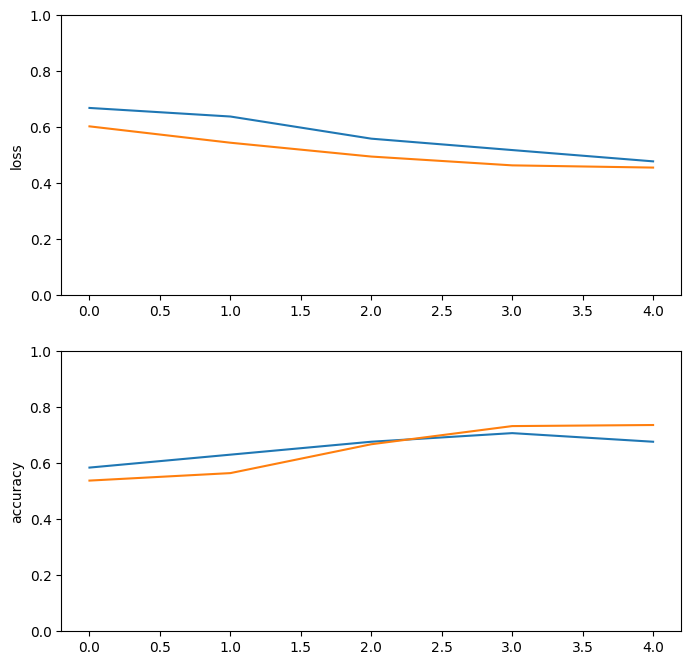

In [142]:
plt.figure(figsize=(8,8))

plt.subplot(2,1,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.ylim(0,1)

plt.subplot(2,1,2)
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.ylabel('accuracy')
plt.ylim(0,1)

# Réentrainer plusieurs couches du modele de base

In [145]:
model.layers[4]

In [144]:
type(keras.applications.mobilenet_v2.preprocess_input)

function